In [2]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.binary_models as binary_models
import model.profile_models as profile_models
import feature.util as feature_util
import feature.make_binary_dataset as make_binary_dataset
import feature.make_profile_dataset as make_profile_dataset
import plot.viz_sequence as viz_sequence
import pandas as pd
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt
import plotting.plots as plots
import json

### Define paths for the model and data of interest

In [34]:
# Define the paths to the files and model, and some constants
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE/profile/config/SPI1/SPI1_training_paths.json"
model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_prior_overfit/1/model_ckpt_epoch_1.pt"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4

In [4]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peaks_bed = files_spec["train_peak_beds"][0]  # First peaks BED, arbitrarily
prof_bigwigs = files_spec["prof_bigwigs"]
assert num_tasks == len(prof_bigwigs) / 2

In [35]:
# Import the model
model = model_util.restore_model(profile_models.ProfileTFBindingPredictor, model_path)
model.eval()
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device) 

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [6]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles, in order of BigWigs given in `prof_bigwigs`
coords_to_vals_list = [
    (
        make_profile_dataset.CoordsToVals(path_1, profile_length),
        make_profile_dataset.CoordsToVals(path_2, profile_length)
    )
    for path_1, path_2 in prof_bigwigs
]
def coords_to_profs(coords):
    return np.stack([
        np.stack([ctv_1(coords), ctv_2(coords)], axis=2)
        for ctv_1, ctv_2 in coords_to_vals_list
    ], axis=1)
# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_profs(coords)
    return input_seq, profs

In [6]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

### Predicting outputs

In [15]:
def predict_coords(coords):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions, the true values from the dataset, and
    the input gradients. The returned profiles are in terms of raw counts, and the
    returned counts are also raw. Returned values are all NumPy arrays.
    """
    input_seqs, profiles = coords_to_network_inputs(coords)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()

    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]

    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    logit_pred_profs, log_pred_counts = model(input_seqs, cont_profs)
    
    # Compute input gradients
    model.zero_grad()
    log_pred_counts.backward(
        model_util.place_tensor(torch.ones(log_pred_counts.size())),
        retain_graph=True
    )
    input_grads = input_seqs.grad * input_seqs
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(logit_pred_profs, axis=2)
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=2)
    
    # Truncate input gradients to profile length
    left = int((input_seqs.shape[1] - profile_length) / 2)
    right = left + profile_length
    input_grads = input_grads[:, left:right, :]
    
    return log_pred_profs.detach().cpu().numpy(), log_pred_counts.detach().cpu().numpy(), true_profs.cpu().numpy(), true_counts.cpu().numpy(), input_grads.detach().cpu().numpy()

### Computing/plotting Fourier transforms

In [21]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [18]:
def plot_grad_and_fft(grads, include_dc=False):
    assert len(grads.shape) == 2
    
    relu_grads = grads.copy()  # Make a copy
    relu_grads[relu_grads < 0] = 0  # Pass through ReLU
    
    sum_abs_grads = np.sum(np.abs(grads), axis=1)
    
    # Take maximum over all 4 channels for each base
    max_relu_grads = np.max(relu_grads, axis=1)
    freqs, mags = dft(max_relu_grads)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal, cut-off gradients, and the DFT
    viz_sequence.plot_weights(grads, subticks_frequency=100)
    fig, ax = plt.subplots(3, 1, figsize=(20, 8))
    ax[0].plot(np.arange(len(max_relu_grads)), max_relu_grads, color="blue")
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("max(ReLU(grad))")
    ax[0].margins(0)
    ax[1].plot(np.arange(len(sum_abs_grads)), sum_abs_grads, color="blue")
    ax[1].set_xlabel("X")
    ax[1].set_ylabel("sum(|grad|)")
    ax[1].margins(0)
    ax[2].plot(freqs, mags, color="red")
    ax[2].set_xlabel("Frequency (radians)")
    ax[2].set_ylabel("|Frequency component|")
    ax[2].margins(0)
    plt.tight_layout()
    plt.show(block=False)
    
    # return freqs, mags

### Plotting the input gradients

In [90]:
# Sample some positive coordinates
pos_coords_table.sample(10)

In [ ]:
# Sample some negative coordinates
neg_coord_sampler.sample_intervals(10)

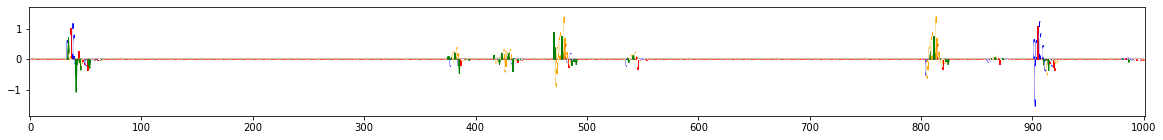

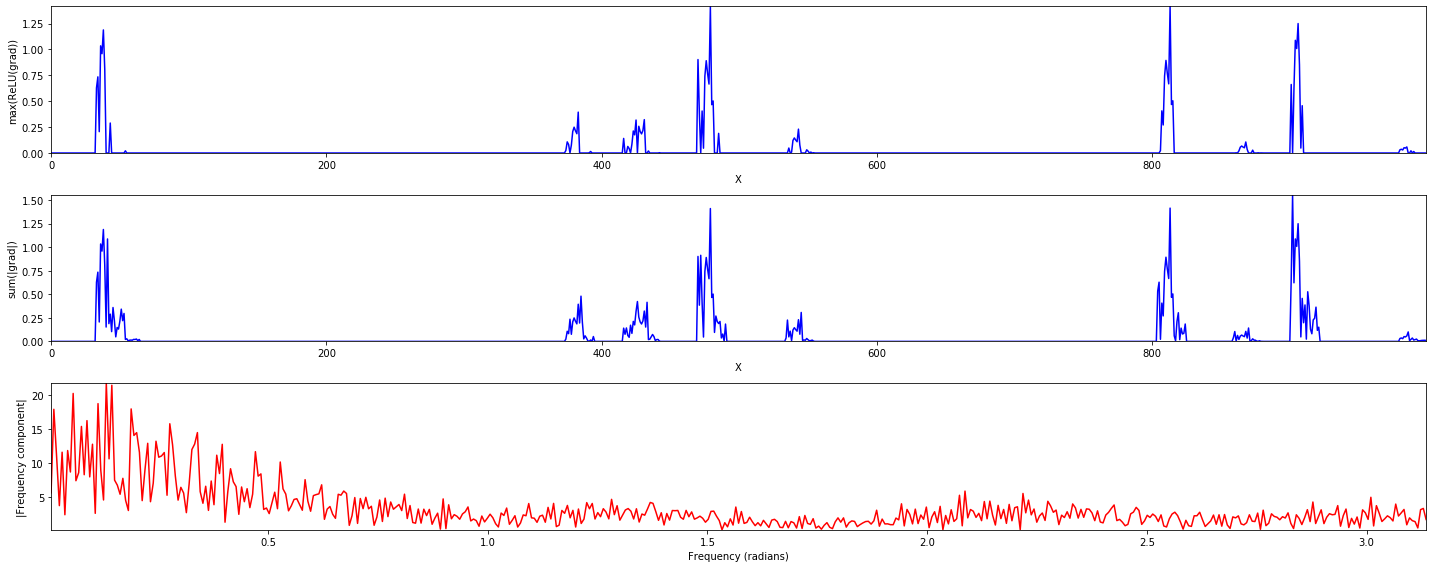

In [36]:
log_pred_profs, log_pred_counts, true_profs, true_counts, input_grads = predict_coords([("chr5", 935336, 936336)])
plot_grad_and_fft(input_grads[0])

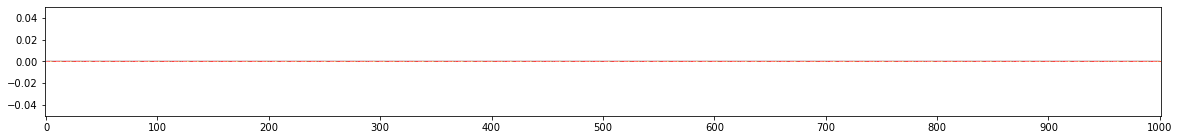

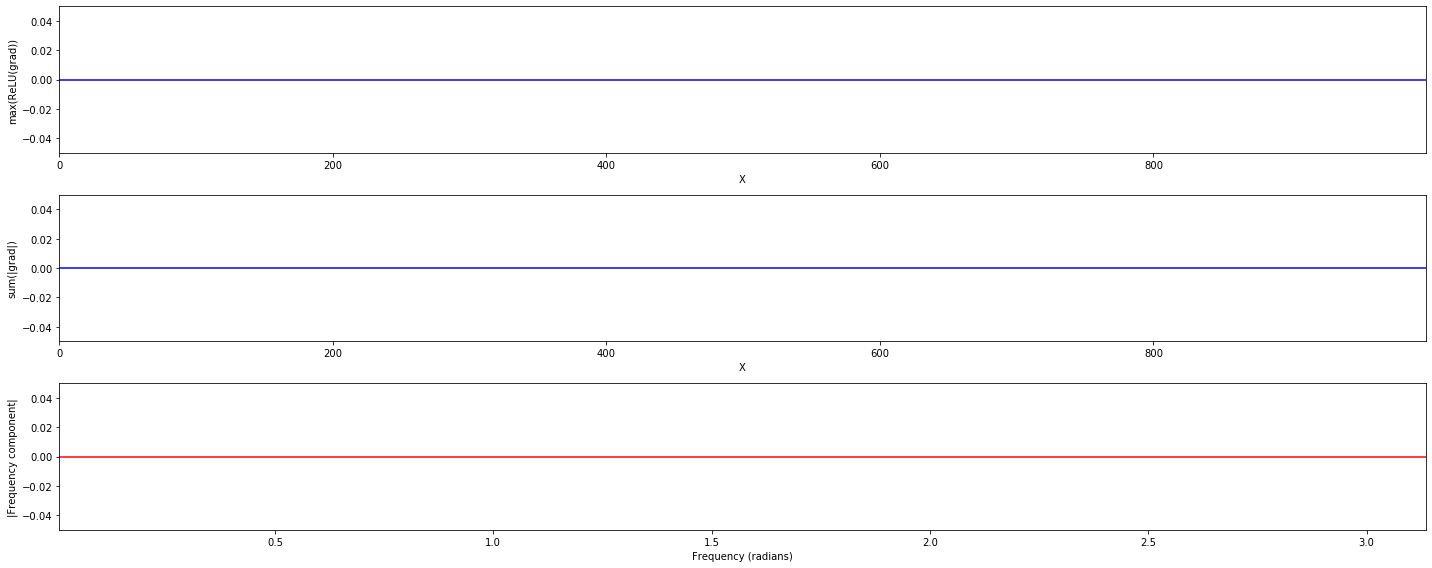

In [37]:
log_pred_profs, log_pred_counts, true_profs, true_counts, input_grads = predict_coords([("chr5", 1000, 2000)])
plot_grad_and_fft(input_grads[0])

['chr9' 60457357 60458703]


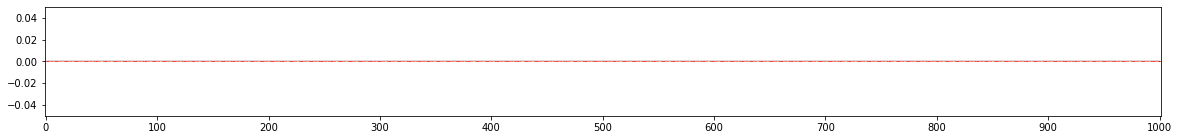

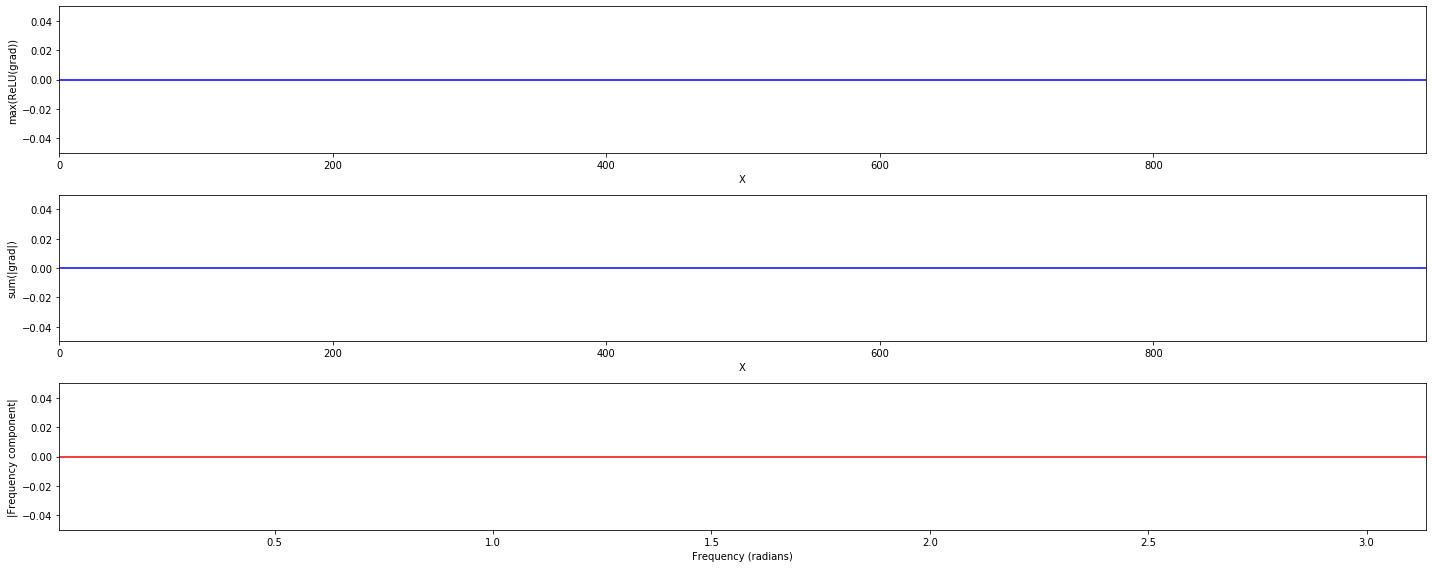

In [171]:
print(neg_coords[10])
plot_grad_and_fft(neg_input_grads[10])

In [158]:
def grad_score_neg(grad):
    """
    Computes score for a negative example given the gradients.
    """
    assert len(grad.shape) == 2
    relu_grad = grad.copy()  # Make a copy
    relu_grad[relu_grad < 0] = 0  # Pass through ReLU
    
    # The entire signal should be as close to 0 as possible
    return np.sum(relu_grad)

In [163]:
def grad_score_pos(grad, freq_limit=0.5):
    """
    Computes score for a positive example given the gradients.
    """
    assert len(grad.shape) == 2
    grad = grad.copy()  # Make a copy
    grad[grad < 0] = 0  # Pass through ReLU
    
    # Take maximum over all 4 channels for each base
    grad = np.max(grad, axis=1)
    freqs, mags = dft(grad)
    
    freqs, mags = freqs[1:], mags[1:]  # Exclude DC
    
    if np.sum(mags):
        mags = mags / np.sum(mags)  # Normalize
    
    # Sum up the area under the low-frequency region
    return np.sum(mags[freqs <= freq_limit])

In [177]:
def plot_score_distributions(pos_grads, neg_grads):
    neg_losses_on_pos = np.array([grad_score_neg(grad) for grad in pos_grads])
    neg_losses_on_neg = np.array([grad_score_neg(grad) for grad in neg_grads])
    pos_losses_on_pos = np.array([grad_score_pos(grad) for grad in pos_grads])
    pos_losses_on_neg = np.array([grad_score_pos(grad) for grad in neg_grads])
    
    # return neg_losses_on_pos, neg_losses_on_neg, pos_losses_on_pos, pos_losses_on_neg
    
    plots.plot_multi_histogram(
        [neg_losses_on_pos, neg_losses_on_neg], ["Positives", "Negatives"], 1, xaxis_gap=4,
        colors=["royalblue", "firebrick"],
        title="Rectified gradient sum", xlabel="Score"
    
    )
    plots.plot_multi_histogram(
        [pos_losses_on_pos, pos_losses_on_neg], ["Positives", "Negatives"], 0.01, xaxis_gap=4,
        colors=["royalblue", "firebrick"],
        title="Sum of low frequency Fourier coefficients on gradients", xlabel="Score"
    )
    

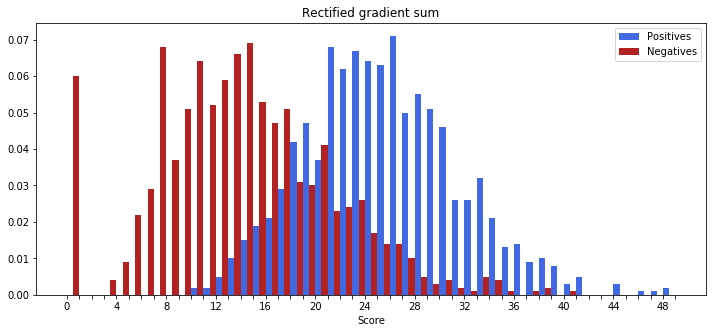

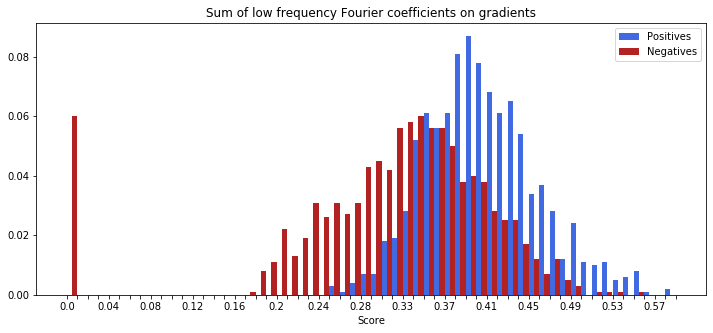

In [179]:
plot_score_distributions(pos_input_grads, neg_input_grads)